---
format:
  html:
    toc: true
    embed-resources: true
    code-fold: false
execute:
  echo: true
---

## Title Classification Model Training

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [4]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [5]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "32G") \
    .config("spark.executor.memory", "16G") \
    .config("spark.executor.memoryOverhead", "4G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9e71241c-b38e-4fad-99c6-1c7c2ea85723;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [6]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
#remove null tag
submissions = submissions.filter(submissions.link_flair_text.isNotNull())
print(f"shape of the comments dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-032393624300/project/submissions/yyyy=*


23/12/07 17:06:19 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/12/07 17:06:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the comments dataframe is 59,459x68
CPU times: user 2.77 s, sys: 173 ms, total: 2.94 s
Wall time: 3min 51s


In [6]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_
from pyspark.ml.feature import StringIndexer


# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("link_flair_text") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# Finisher
finisher = Finisher() \
    .setInputCols(["normalized"])

# Pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher
])

# Apply the pipeline
processed_tags_df = nlp_pipeline.fit(submissions).transform(submissions)


# Text Processing for Title and Selftext (Body)

# Document Assemblers for title and selftext
title_assembler = DocumentAssembler().setInputCol("title").setOutputCol("title_document")
selftext_assembler = DocumentAssembler().setInputCol("selftext").setOutputCol("selftext_document")

# Tokenizers for title and selftext
title_tokenizer = Tokenizer().setInputCols(["title_document"]).setOutputCol("title_token")
selftext_tokenizer = Tokenizer().setInputCols(["selftext_document"]).setOutputCol("selftext_token")

# Normalizers for title and selftext
title_normalizer = Normalizer().setInputCols(["title_token"]).setOutputCol("title_normalized").setLowercase(True)
selftext_normalizer = Normalizer().setInputCols(["selftext_token"]).setOutputCol("selftext_normalized").setLowercase(True)

# Finishers for title and selftext
title_finisher = Finisher().setInputCols(["title_normalized"]).setOutputCols(["finished_title_normalized"]).setOutputAsArray(True)
selftext_finisher = Finisher().setInputCols(["selftext_normalized"]).setOutputCols(["finished_selftext_normalized"]).setOutputAsArray(True)


# Extended NLP Pipeline
extended_nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher,
    title_assembler,
    title_tokenizer,
    title_normalizer,
    title_finisher,
    selftext_assembler,
    selftext_tokenizer,
    selftext_normalizer,
    selftext_finisher
])

# Apply the extended pipeline
extended_processed_df = extended_nlp_pipeline.fit(submissions).transform(submissions)

from pyspark.ml.feature import CountVectorizer

# CountVectorizer for each text feature
cv_text = CountVectorizer(inputCol="finished_normalized", outputCol="cv_text_features")
cv_title = CountVectorizer(inputCol="finished_title_normalized", outputCol="cv_title_features")
cv_selftext = CountVectorizer(inputCol="finished_selftext_normalized", outputCol="cv_selftext_features")

# Fitting and transforming
model_text = cv_text.fit(extended_processed_df)
model_title = cv_title.fit(extended_processed_df)
model_selftext = cv_selftext.fit(extended_processed_df)

df_with_features = model_text.transform(extended_processed_df)
df_with_features = model_title.transform(df_with_features)
df_with_features = model_selftext.transform(df_with_features)

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Prepare the Label Column with handling invalid values
label_indexer = StringIndexer(inputCol="link_flair_text", outputCol="label", handleInvalid="keep")
df_with_features = label_indexer.fit(df_with_features).transform(df_with_features)

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=["cv_text_features", "cv_title_features", "cv_selftext_features"], outputCol="features")
final_prepared_df = assembler.transform(df_with_features)
training_data, testing_data = final_prepared_df.randomSplit([0.6, 0.4], seed=42)

### Load the model to Predict and print the predict result

In [7]:
from pyspark.ml.classification import LogisticRegressionModel

# Evaluate best model
# Load a pre-trained model
lrModel = LogisticRegressionModel.load("../../data/models/best_logistic_regression_model")

In [8]:
# Make predictions on the new data
predictions = lrModel.transform(testing_data)
predictions.select("label","prediction", "probability").show()

23/12/07 09:15:15 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[1.0,2.2574461237...|
|  0.0|       0.0|[0.99999429112962...|
|  1.0|       1.0|[1.56182057744478...|
|  0.0|       0.0|[1.0,3.2186355964...|
|  1.0|       1.0|[2.81837635406791...|
|  4.0|       4.0|[9.27858568667229...|
|  0.0|       0.0|[1.0,3.9805376240...|
|  1.0|       1.0|[2.35222368714639...|
|  0.0|       0.0|[1.0,1.2301904949...|
|  0.0|       0.0|[1.0,1.0298742724...|
|  1.0|       0.0|[1.0,1.7401249905...|
|  1.0|       1.0|[1.53576186600649...|
|  2.0|       2.0|[4.55599402455953...|
|  1.0|       1.0|[7.96642016175923...|
|  0.0|       0.0|[1.0,8.2526283755...|
|  1.0|       1.0|[2.29613276177369...|
|  1.0|       1.0|[1.96106700064173...|
|  0.0|       0.0|[1.0,5.8391558668...|
|  7.0|       7.0|[3.81266501720795...|
|  0.0|       0.0|[1.0,1.5822241615...|
+-----+----------+--------------------+
only showing top 20 rows



23/12/07 09:15:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


### Make the predict result more readable

In [14]:
if 'label' in df_with_features.columns:
    df_with_features = df_with_features.drop('label')

# Fit the StringIndexer model and get the label mapping
label_indexer_model = label_indexer.fit(df_with_features)
original_labels = label_indexer_model.labels

# Create a dictionary to map numerical labels to string labels
label_dict = {i: label for i, label in enumerate(original_labels)}

# Your existing UDF definition and the rest of the code
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def replace_label(num_label):
    return label_dict.get(num_label, "Unknown")

replace_label_udf = udf(replace_label, StringType())

predictions_with_tags = predictions.withColumn("predictedLabel", replace_label_udf(predictions["prediction"]))
predictions_with_tags = predictions_with_tags.withColumn("ActualLabel", replace_label_udf(predictions["label"]))

predictions_with_tags.select("ActualLabel","predictedLabel").show(truncate=False)



23/12/07 09:22:50 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB


+-----------------------------+-----------------------------+
|ActualLabel                  |predictedLabel               |
+-----------------------------+-----------------------------+
|Question                     |Question                     |
|Question                     |Question                     |
|FOTD                         |FOTD                         |
|Question                     |Question                     |
|FOTD                         |FOTD                         |
|Rule 2 Removal: Photo Editing|Rule 2 Removal: Photo Editing|
|Question                     |Question                     |
|FOTD                         |FOTD                         |
|Question                     |Question                     |
|Question                     |Question                     |
|FOTD                         |Question                     |
|FOTD                         |FOTD                         |
|Discussion                   |Discussion                   |
|FOTD   

### Prediction Visualization

A insightful way to visualize the predictions data is through a bar chart comparing the actual and predicted counts for each label. 

In [15]:
from pyspark.sql.functions import col, count

# Counting the number of actual occurrences for each label
actual_counts = predictions_with_tags.groupBy("ActualLabel").agg(count(col("ActualLabel")).alias("ActualCount"))

# Counting the number of predicted occurrences for each label
predicted_counts = predictions_with_tags.groupBy("predictedLabel").agg(count(col("predictedLabel")).alias("PredictedCount"))

# Convert to Pandas DataFrame
actual_counts_pd = actual_counts.toPandas()
predicted_counts_pd = predicted_counts.toPandas()



23/12/07 09:23:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/07 09:26:32 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/12/07 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB
23/12/07 09:29:50 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB


In [16]:
# Merging the dataframes on labels
merged_counts = pd.merge(actual_counts_pd, predicted_counts_pd, left_on='ActualLabel', right_on='predictedLabel')

# Dropping duplicate columns
merged_counts = merged_counts.drop(columns=['predictedLabel'])

In [17]:
# Save to a CSV file
csv_file_path = '../../data/csv/title_classification_merged_counts.csv'
merged_counts.to_csv(csv_file_path, index=False)

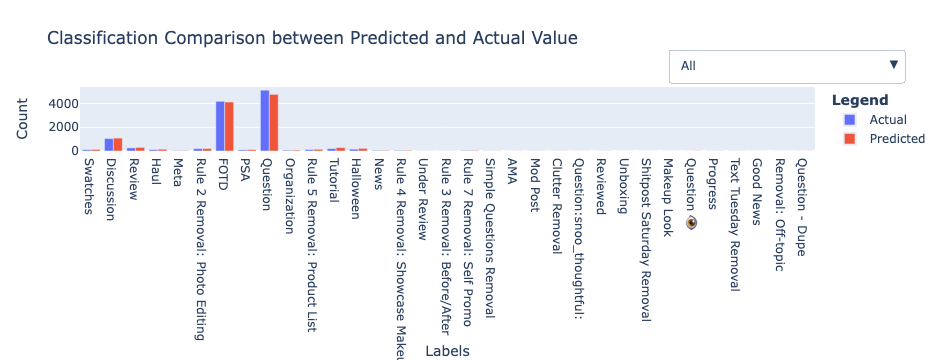

In [19]:
import pandas as pd
import plotly.graph_objects as go
merged_counts = pd.read_csv('../../data/csv/title_classification_merged_counts.csv')
# Initialize the figure with grouped bar chart for the 'All' selection
fig = go.Figure(data=[
    go.Bar(name='Actual', x=merged_counts['ActualLabel'], y=merged_counts['ActualCount']),
    go.Bar(name='Predicted', x=merged_counts['ActualLabel'], y=merged_counts['PredictedCount'])
])

# Add a set of bars for each label, these will be hidden initially
for label in merged_counts['ActualLabel']:
    actual = merged_counts[merged_counts['ActualLabel'] == label]['ActualCount'].values[0]
    predicted = merged_counts[merged_counts['ActualLabel'] == label]['PredictedCount'].values[0]
    fig.add_trace(go.Bar(name=f'Actual - {label}', x=[label], y=[actual], visible=False))
    fig.add_trace(go.Bar(name=f'Predicted - {label}', x=[label], y=[predicted], visible=False))

# The initial button that shows all labels
buttons = [dict(label='All',
                method='update',
                args=[{'visible': [True, True] + [False] * (len(merged_counts) * 2),
                       'title': 'All'}])]

# Add buttons for each label in the dropdown
for i, label in enumerate(merged_counts['ActualLabel']):
    # Set visibility: only the two traces for the selected label are visible
    visibility = [False] * 2 + [i*2 == j or i*2+1 == j for j in range(len(merged_counts) * 2)]
    button = dict(label=label,
                  method='update',
                  args=[{'visible': visibility,
                         'title': label}])
    buttons.append(button)

# Update the layout with the dropdown
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'active': 0,
        'x': 0.8,
        'y': 1.6,
        'xanchor': 'left',
        'yanchor': 'top'
    }],
    title = "Classification Comparison between Predicted and Actual Value",
    xaxis_title='Labels',
    yaxis_title='Count',
    barmode='group',
    legend_title='<b>Legend</b>',
    legend=dict(
        traceorder='normal',
        itemsizing='constant'
    )
)

# Show the figure
fig.show()

In [20]:
# Save the figure to an HTML file
html_file_path = '../../data/plots/title_classification_interactive_bar_chart.html'
fig.write_html(html_file_path)

The visualization of classification results, as presented in the bar charts, eloquently captures the predictive prowess of the model across a diverse range of categories. In particular, the alignment between the actual and predicted values in nuanced classifications, such as "Face of the Day" (FOTD) and thematic labels like "Halloween," underscores the model's adeptness at discerning and leveraging intricate patterns within the data. This level of accuracy is indicative of a well-trained model that has effectively captured the underlying distributions and characteristics of each category. The uniformity in prediction across several labels points to a sophisticated understanding by the model of the domain-specific features, which is crucial in scenarios demanding high precision. Moreover, the clarity of these visual depictions serves not just as a reflection of the model's current state of performance but also as a compelling narrative of its potential to deliver actionable insights in real-world settings, making it a valuable asset for decision-making processes.